# To run the code:
run the two cell below
then start from tranformer training


In [1]:
from google.colab import drive
drive.mount('/content/drive')
current_path = '/content/drive/MyDrive/ucb_r/embedding'

Mounted at /content/drive


In [14]:
import os
import io
import pandas as pd
import ast
import numpy as np
import json
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import math
from tqdm import tqdm

from keras.backend import dot
import statsmodels.stats.api as sms
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
import scipy.stats as st
import random

## unzip file
only need to implement once

In [ ]:
# unzip the file
file_path='/content/drive/MyDrive/ucb_r/dataset/top5k.zip'
unzip_path='/content/drive/MyDrive/ucb_r/embedding/top5k/top3k'
unzip_file_path=os.path.join(current_path,'dataset')
# ! unzip -d $unzip_path $file_path
for file in os.listdir(unzip_path):
  if file.endswith('.zip'):
    folder=os.path.join(unzip_file_path,file.split('.')[0])
    if os.path.exists(folder):
      continue
    print(file)
    file_path=os.path.join(unzip_path,file)
    ! unzip -d $folder $file_path


## load file and map

In [ ]:
def read_dat_file(dat_file):
  '''
  read dat file and return a dict
  being called by generate_sequence()
  directly use genearte_sequence() to generate sequence
  '''
  data = pd.read_csv(dat_file, sep='\t')
  data=data.columns[0]
  # data = ast.literal_eval(data)
  file_like_object = io.StringIO(data)  # Import io module for StringIO
  json_data = json.load(file_like_object)
  return json_data

def generate_sequence(dat_file):
    '''
    read the dat file and generate a sequence
    the code below allow duplicated time
    '''
    data = read_dat_file(dat_file)
    # print(data.keys())
    time_length = len(list(d['_time'] for d in data["_notes"]))
    # using set() mean that we don't want the duplicated time
    # using list() means that we can accept the suplicated time
    # print('len of list', len(list(d['_time'] for d in data["_notes"])))
    # print('len of set ', len(set(d['_time'] for d in data["_notes"])))
    # The parsed notes is in the form of (unique time , possible combination of exact time + note block)
    parse_array = np.zeros((time_length, 1+4+3+4+9))
    cur_index = -1
    for item in data["_notes"]:
        cur_index += 1
        parse_array[cur_index, 0] = item["_time"]
        parse_array[cur_index, 1+item["_lineIndex"]] = 1
        parse_array[cur_index, 5+item["_lineLayer"]] = 1
        parse_array[cur_index, 8+item["_type"]] = 1
        parse_array[cur_index, 12+item["_cutDirection"]] = 1
    return parse_array

### exmaple

In [ ]:
example_path ='/content/drive/MyDrive/ucb_r/embedding/dataset/AB3A1D7CACA41FA251077D572C7ED4C5FA53DF17'
#example_path ='/content/drive/MyDrive/ucb_r/embedding/dataset/a949bb798e16a81092e54a38b78eb1375f06e49f'
print(os.listdir(example_path))
for file in os.listdir(example_path):
  if file.endswith('.dat') and not file.startswith('info') and not file.startswith('Info') and not file.startswith('EasyLightshow'):
    print("-------file name-------",file)
    # data=read_dat_file(os.path.join(example_path,file)) # the dict
    # print(find_invalid_positions_in_dict_format(os.path.join(example_path,file)))
    parse_array=generate_sequence(os.path.join(example_path,file)) # np array
    '''
    print(parse_array.shape)
    print(parse_array)
    print(parse_array[0])
    print(parse_array[0][0])

    print(data.keys())
    print("data file 3 notes", data['_notes'][:3])
    '''


['alice.png', 'HardStandard.dat', 'EasyStandard.dat', 'NormalStandard.dat', 'song.egg', 'cinema-video.json', 'cover.jpg', 'ExpertStandard.dat', 'Info.dat', 'ExpertPlusStandard.dat']
-------file name------- HardStandard.dat
-------file name------- EasyStandard.dat
-------file name------- NormalStandard.dat
-------file name------- ExpertStandard.dat
-------file name------- ExpertPlusStandard.dat


### mapping

load the mapping.json, map the maps to leaderboard ID

In [ ]:
path_to_map = os.path.join(current_path,'mapping.json')
f = open(path_to_map)
mapping = json.load(f)
print(mapping)

reversed_mapping = {}
for key, value in mapping.items():
    reversed_mapping.setdefault(value, []).append(key)
print(reversed_mapping)

{'151': 'fda568fc27c20d21f8dc6f3709b49b5cc96723be', '771': 'b9867cdccf8b27d7a174c861adc69215c86cdab8', '971': '2aa1f5192828e075c30dd015b1e132bba912eb86', '2171': 'c807689fefdae82aa79ba9c7f861118fb426b4cc', '2751': 'b742641ea661d824dfb082a7470b2d0aa7fc984e', '2971': 'c1c8e2b9394050afad435608137941da0b64b8f3', '3971': 'df7e75ab20b9a27960c9f95e9f2b5ad0927c46dc', '4251': 'be1a39b41f2089cad9aa8d775f55e8707447b5ca', '4851': 'c5b3f2eba33f96f9d0e052f02768898134ca2109', '6371': 'c030b7893e8c2739abfe037c9e478b0774151e4d', '6571': 'f16443de4216fc5f9435f103d77a6919423edb8a', '7371': '6df1fc9961e35705028c852c2514f115d3ba41fc', '12451': '9a1d001995cc0a2014352aa7148cbcbf2e489d89', '12571': 'f8509410634644b6544bdd3ac54fdd7453d285af', '14131': '8e7e553099436af31564adf1977a5ec42a61cfff', '14151': '8e7e553099436af31564adf1977a5ec42a61cfff', '14171': '8e7e553099436af31564adf1977a5ec42a61cfff', '15551': 'fbd8b9338bffb98555a10c69887234fac959d83d', '15571': 'fbd8b9338bffb98555a10c69887234fac959d83d', '15591'

In [ ]:
file_list=os.listdir(os.path.join(current_path,'dataset'))
print(file_list)

file_list_mapping = [reversed_mapping.get(file) for file in file_list]
print(file_list_mapping)

['a79af292ca03aca894e7acc3bd8c3cacfddf2906', 'a7b222972e15f7efb4fbf764be3bd274eab2cd73', 'a7f52a8c3c6ee6eb2f9bc89dc6bb7826a1f5039f', 'a84b0f9a583faa8bd2e3f67bd181cc3f4678c08c', 'a868c5f6223de645cff4f74f87d081d1756f8fef', 'a8874ee415b90a91f116cf9089262bd068f06563', 'A8A9C5C92DDA20FE574EB14DA23130933563B0F3', 'A8ACE5768613608161829A4D345EFD80E532EE08', 'a8df2df28d239a14b18f40855045eaca88a0c8e5', 'A8E7157E5B2C57FDFA871DD9306EFC34F8596736', 'a8e98bf514597f94b610c80a2ed229419fdf7650', 'a8f0463483930857ce37519399cebab3c6a1fce7', 'A94286B23546ECA3C4007225484B3F33077EF376', 'a949bb798e16a81092e54a38b78eb1375f06e49f', 'A98B99B91A82D4F930EF71C81FCD21E2FB269AD4', 'a9968d2d7979606f57e2988d44189db7de8cf0e4', 'A9E51BA17663C7FC9B15EB93F3BFF3D31D721A9A', 'A9E696B8F2314B1EC5A7D8D669A6B6F9E9579501', 'a9ff645fca89658bd536784b0a6cb790771861a2', 'aa0a150d83b499c8becc3beda1c17ac4d9d97d40', 'aa0a3e6c388a98731c313c9a532f476cc00642c3', 'AA19FA6FB24518C09F11E2010A31620354BFFBEA', 'aa2f7bf0df25cd57dddac159fa7c15

#### load factorize_unique_categories.json and map leaderboard ID to number

In [ ]:
with open(os.path.join(current_path,'factorize_unique_categories.json'), 'r') as file:
  unique_categories = json.load(file)
print(len(unique_categories))
print(unique_categories)

result = [[unique_categories.index(item) if item in unique_categories else -1 for item in inner_list] for inner_list in file_list_mapping]
print('map to number', )
'''
Each sublist correspond to a map folder (a song), there are more than one value because mapping.json have multiple ID to the map.
It has no relation with the number of dat file in the folder.
'''
'''
with open(os.path.join(current_path,'mapping_reult.json'), 'w') as file:
  json.dump(result, file)'''

1023
['16e9791', '1f6fa91', 'ba4071', '1821871', '1aafc71', '1e07d71', 'f58351', '4adb91', '271171', '19be191', '1ad6671', '4adb71', 'f92291', '12b2751', '68bb91', 'b72471', '18f5d91', '1697371', '1685891', '12bd271', '1a2f671', '1232e71', 'b4ff91', '1ae1251', '1d3f171', '197ba91', 'd00c91', '19b2771', '1a1e591', '1d70971', '1e07d51', '849a91', '11cf897', '78a851', '1e19991', 'ca4091', 'd77191', '1ac4771', '1791451', '194b491', '1fc8591', '1e8fe91', '214491', '1c3e171', '6b8c91', '194b471', '1a2cd51', '1ac5671', '1c20891', 'f12471', 'f12491', '12bd251', '11d7a91', '1bb8691', '18fdf91', '49fc71', '13d0191', '19b9791', '142f451', '1362d51', '182bc91', '1dc9451', '1ad5591', '1911b11', '1bf7671', '1442731', '1ac0c51', '1bb8d71', '1958091', '1a01671', '1ac0c71', '1a32a91', '1410791', '1a9e871', '1fb3a91', '1583691', '1a3e191', '119f091', '138ba51', '303691', '1d49071', '11c7771', '1949e71', '1ff071', '1743471', '1acf571', '57031', '688871', '17f3891', '10f6b71', '1ffb671', '1c5fd91', '1cce6

"\nwith open(os.path.join(current_path,'mapping_reult.json'), 'w') as file:\n  json.dump(result, file)"

In [ ]:
all_labeled_data=[]
all_labeled_map=[]
filefolder_index=0
for index in range(len(result)):
  #for sublist in result:
  sublist=result[index]
  if len([i for i in sublist if i != -1])!=0:

    file_dir=file_list[index]
    files=os.listdir(os.path.join(current_path,'dataset',file_dir))
    ID_list=file_list_mapping[index]
    for i in range(len(sublist)):
      if sublist[i]!=-1:
        hard_level=ID_list[i][-2:]
        if(hard_level=='11'):
          for j in (files):
            if('.dat' in j) and ('asy' in j):
              all_labeled_data.append([file_dir,j,ID_list[i],sublist[i]])
              break;
        elif(hard_level=='31'):
          for j in (files):
            if ('.dat' in j) and ('ormal' in j):
              all_labeled_data.append([file_dir,j,ID_list[i],sublist[i]])
              break;
        elif(hard_level=='51'):
          for j in (files):
            if ('.dat' in j) and (('Hard' in j) or ('hard'in j)) :
              all_labeled_data.append([file_dir,j,ID_list[i],sublist[i]])
              break;
        elif(hard_level=='71'):
          for j in (files):
            if ('.dat' in j) and ('xpert' in j) and ('lus' not in j):
              all_labeled_data.append([file_dir,j,ID_list[i],sublist[i]])
              break;
        elif(hard_level=='91'):
          for j in (files):
            if ('.dat' in j) and ('lus' in j) and ('xpert' in j):
              all_labeled_data.append([file_dir,j,ID_list[i],sublist[i]])
              break;
        else:
          print('don\'t find file ', file_dir,ID_list[i],sublist[i])

'''
    print(sublist)
    print(file_list_mapping[filefolder_index])
    print(os.listdir(os.path.join(current_path,'dataset',file_list[filefolder_index])))
  filefolder_index+=1

    all_labeled_data.append([file_list[filefolder_index]]+[i for i in sublist if i != -1])
    all_labeled_map.append(file_list[filefolder_index])
  filefolder_index += 1
print(all_labeled_data)
with open(os.path.join(current_path,'all_labeled_data.json'), 'w') as file:
  json.dump(all_labeled_data, file)'''

don't find file  825dbd980eadceaba54c8e9d8e68f93a1b4cb029 1421c97 518
don't find file  875f9f57103004aca7c4bfac57601d21402cdb10 10c9b97 583
don't find file  89b1de26baad93c63a6bdb3d9dbae7dc4972897b ed2a97 784
don't find file  1dba42e346e0c68f7ed6443e0bb766ee07928e94 148e997 646
don't find file  2aa85aad10e124eb674d18d49251bc94ee1a4283 11cf897 32
don't find file  448D219117992026EB23C98DC920CE73A912F289 1e6ffx97 956


"\n    print(sublist)\n    print(file_list_mapping[filefolder_index])\n    print(os.listdir(os.path.join(current_path,'dataset',file_list[filefolder_index])))\n  filefolder_index+=1\n\n    all_labeled_data.append([file_list[filefolder_index]]+[i for i in sublist if i != -1])\n    all_labeled_map.append(file_list[filefolder_index])\n  filefolder_index += 1\nprint(all_labeled_data)\nwith open(os.path.join(current_path,'all_labeled_data.json'), 'w') as file:\n  json.dump(all_labeled_data, file)"

In [ ]:
for i in all_labeled_data:
  print(i)

['a7b222972e15f7efb4fbf764be3bd274eab2cd73', 'ExpertPlusStandard.dat', '176e391', 650]
['a868c5f6223de645cff4f74f87d081d1756f8fef', 'ExpertPlusStandard.dat', 'ca6291', 278]
['a8f0463483930857ce37519399cebab3c6a1fce7', 'ExpertPlusStandard.dat', '1a60591', 266]
['a949bb798e16a81092e54a38b78eb1375f06e49f', 'NormalStandard.dat', '1442731', 65]
['a949bb798e16a81092e54a38b78eb1375f06e49f', 'HardStandard.dat', '1442751', 548]
['a949bb798e16a81092e54a38b78eb1375f06e49f', 'ExpertPlusStandard.dat', '1442791', 543]
['aa2f7bf0df25cd57dddac159fa7c159f732e0553', 'Expert.dat', '48071', 398]
['aa31dcd3f9da483793922d24f210944178b6cbc2', 'ExpertStandard.dat', '1232e71', 21]
['aa31dcd3f9da483793922d24f210944178b6cbc2', 'HardStandard.dat', '1232e51', 306]
['AB3A1D7CACA41FA251077D572C7ED4C5FA53DF17', 'ExpertPlusStandard.dat', '26d33xx91', 984]
['ab545725e837496295bb5c0321f63044d77a958c', 'ExpertStandard.dat', '18aba71', 153]
['abe3086c23ba2c8f7c92620f8b612c576768e295', 'ExpertStandard.dat', '1a3e171', 230]

In [ ]:
print('# of maps: ',len(file_list))
print('# of labeled maps: ', len(all_labeled_data))
all_labeled_map=[os.path.join(current_path,'dataset',i[0],i[1]) for i in all_labeled_data]
with open(os.path.join(current_path,'all_labeled_data.json'), 'w') as file:
  json.dump(all_labeled_data, file)

# of maps:  2902
# of labeled maps:  1012


## generate training set and test set

In [ ]:
with open(os.path.join(current_path,'all_labeled_data.json'), 'r') as file:
  all_labeled_data=json.load(file)
all_labeled_map=[os.path.join(current_path,all_labeled_data[i][0],all_labeled_data[i][1]) for i in all_labeled_data]

In [ ]:
print(len(os.listdir(os.path.join(current_path,'dataset'))))

2902


In [ ]:

data=[]
data_index=[]
for index in range(len(all_labeled_data)):
  try:
    data.append(generate_sequence(all_labeled_map[index]))
    data_index.append(all_labeled_data[index][-1])
  except:
    print(all_labeled_map[index])
    continue
  print(data_index[-1])

print('data length ', len(data))
print('data_index length ', len(data_index))
print('shape of first 3 data', data[0].shape,data[1].shape,data[2].shape)
print('data_index of first three data',data_index[0:3])


650
278
266
65
548
543
398
21
306
984
153
230
76
712
584
413
289
788
467
1017
622
39
45
474
519
768
238
498
803
640
262
656
724
923
854
155
137
157
90
272
27
466
472
104
57
870
1004
811
617
704
990
403
171
485
620
642
538
211
332
728
/content/drive/MyDrive/ucb_r/embedding/dataset/B96AE58987D3B87247F4B1AA996CF999E4F68B21/ExpertStandard.dat
158
756
598
462
227
582
929
663
545
577
564
84
334
119
447
445
260
512
556
/content/drive/MyDrive/ucb_r/embedding/dataset/bd1e8b2ee9b1095f0eebe670f0f79136c39b5ec7/ExpertPlusStandard.dat
840
837
17
213
/content/drive/MyDrive/ucb_r/embedding/dataset/bdebd0e4b5df0a8ad592e04d294c8e3df4248667/ExpertStandard.dat
795
/content/drive/MyDrive/ucb_r/embedding/dataset/bdebd0e4b5df0a8ad592e04d294c8e3df4248667/HardStandard.dat
103
379
399
293
895
894
892
720
/content/drive/MyDrive/ucb_r/embedding/dataset/BF86263DEDA5F2E09867F3DDAD625DFC269709BE/ExpertPlus.dat
139
935
256
40
191
309
92
/content/drive/MyDrive/ucb_r/embedding/dataset/C15584EDA9D87646EC657442B91B117092

In [ ]:
data_index = np.array(data_index, dtype=np.int32)
np.save(os.path.join(current_path,'data.npy'), data)
np.save(os.path.join(current_path,'data_index.npy'), data_index)


/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
print('data length ', len(data))
print('data_index length ', len(data_index))
print('shape of first 3 data', data[0].shape,data[1].shape,data[2].shape)
print('data_index of first three data',data_index[0:3])

data length  949
data_index length  949
shape of first 3 data (2714, 21) (875, 21) (682, 21)
data_index of first three data [650 278 266]


## load score-prediction data to generate vector

In [ ]:
model_score_prediction = load_model(os.path.join(current_path,"model_score_prediction.h5"))

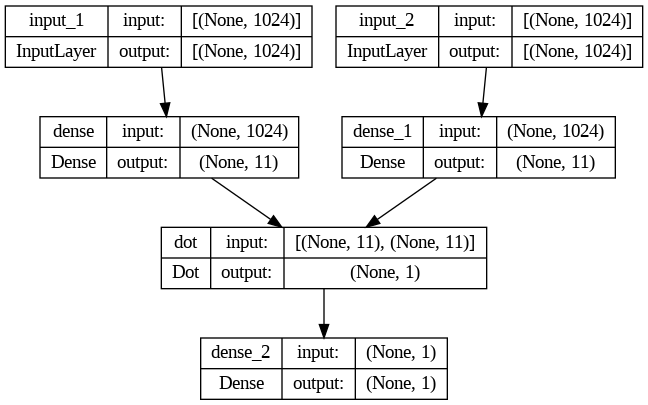

In [ ]:
keras.utils.plot_model(model_score_prediction, show_shapes=True, show_layer_names=True)


In [ ]:
print(model_score_prediction.layers[0].name)
print(model_score_prediction.layers[2].name)

input_1
dense


In [ ]:
model_get_embedding = keras.Model(inputs=model_score_prediction.input[0], outputs=model_score_prediction.layers[2].output)

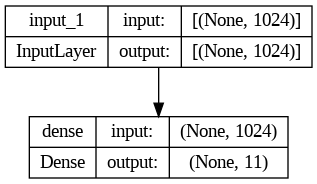

In [ ]:
keras.utils.plot_model(model_get_embedding, show_shapes=True, show_layer_names=True)

In [ ]:
print(data_index)
X_maps = tf.one_hot(data_index, depth=1024)
print(X_maps.shape)


[ 650  278  266   65  548  543  398   21  306  984  153  230   76  712
  584  413  289  788  467 1017  622   39   45  474  519  768  238  498
  803  640  262  656  724  923  854  155  137  157   90  272   27  466
  472  104   57  870 1004  811  617  704  990  403  171  485  620  642
  538  211  332  728  158  756  598  462  227  582  929  663  545  577
  564   84  334  119  447  445  260  512  556  840  837   17  213  795
  103  379  399  293  895  894  892  720  139  935  256   40  191  309
   92  364   34   46  224  535  265  350  769  896  905  801  534  381
  890  824  623  845  189  546  881  619  461  761  401  676  751  550
  572  198   67  360  174  621   75  668  798  737   68  128    7   11
  670  703  343  313  562  491  980  981  721  723  402  126  789  389
  831  502  298   79  295  762  632  340  336  779   95  201    8  674
  326  229  989  342  418  195  587  554  375  821  613  652  868  194
  862  365  207  307  221  184  181  514  520  879  449   69  508  641
  200 

In [ ]:
embedding = model_get_embedding.predict(X_maps)
print(embedding.shape)


30/30 [==============================] - 3s 1ms/step
(949, 11)


In [ ]:
print(embedding)
print(type(embedding))
print(embedding.shape)


[[-0.03011928  0.24641241 -0.09036453 ... -0.41850984 -0.02132589
  -0.2041199 ]
 [ 0.04543971 -0.03218893 -0.04823846 ... -0.02334535  0.23967794
  -0.37657762]
 [-0.24692097 -0.05858017 -0.28264242 ... -0.10663653  0.18542261
  -0.35311344]
 ...
 [-0.03451564 -0.22007057  0.4394954  ... -0.40301502  0.21273243
  -0.42999238]
 [-0.11092657  0.18017349 -0.1190421  ... -0.24699914  0.22033744
  -0.18446793]
 [-0.0616783  -0.04841368 -0.23856771 ... -0.1741114   0.27726084
  -0.30935466]]
<class 'numpy.ndarray'>
(680, 11)


In [ ]:
np.save(os.path.join(current_path,'embedding_data.npy'), embedding)


## transformer training

### load data and label

In [139]:
data=np.load(os.path.join(current_path,'data.npy'), allow_pickle=True)
label=np.load(os.path.join(current_path,'embedding_data.npy'),allow_pickle=True)
# preprocess
src_len=1000
list_empty=[]
for i in range(len(data)):
  if(len(data[i])==0):
    list_empty.append(i)
    continue
  if(((data[i].shape)[0])<src_len):

    data[i]=np.pad(data[i], ((0,src_len - data[i].shape[0]), (0, 0)), 'constant')
  else:
    data[i]=data[i][:src_len,:]
data = np.delete(data, list_empty,axis=0)
label = np.delete(label, list_empty, axis=0)

In [ ]:
for i in range(data.shape[0]):
  print(i)
  a=data[i][:,0]
  set_a=set(a)
  dixt_a={}
  for j in range(len(set_a)):
    dixt_a[list(set_a)[j]]=j
  b=[dixt_a[j] for j in a]
  data[i][:,0]=b

In [143]:
X_train=data[:int(len(data)*0.8)]
X_train= np.vstack(X_train).reshape(int(len(data)*0.8), data[0].shape[0], data[0].shape[1])
y_train=label[:int(len(data)*0.8)]
X_test=data[int(len(data)*0.8):]
print(X_test.shape)
X_test=np.vstack(X_test).reshape(len(data)-int(len(data)*0.8), data[0].shape[0], data[0].shape[1])
y_test=label[int(len(data)*0.8):]

(186,)


In [148]:
'''
for each map, the time is different, I think it's better to use different time encoding in different maps
custom position encoding
'''
class PositionalEncoding(nn.Module):
    def __init__(self,batch_size, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        self.d_model=d_model
        self.batch_size=batch_size
        self.max_len=max_len

    def forward(self, x,position):
        pe = torch.zeros(self.batch_size,self.max_len, self.d_model)
        # position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1)

        position=torch.tensor(position).unsqueeze(2)
        # print(position.shape)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)).reshape((1,1,-1)).cuda()
        # print(div_term.shape)
        pe[:, :,0::2] = torch.sin(position * div_term)
        pe[:,:, 1::2] = torch.cos(position * div_term)
        x = x + pe[:,:x.size(1), :].cuda()
        return self.dropout(x)
'''

class PositionalEncoding(nn.Module):
    def __init__(self,batch_size, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x,position):
        # print(self.pe[:,:10,:3])
        # print(self.pe.shape)
        x = x + self.pe[:,:x.size(1), :]
        return self.dropout(x)
'''
class GET_EMB(nn.Module):
    def __init__(self,input_size,embedding_dim, hidden_size, num_layers, output_size,batch_size,max_len=5000):
        super().__init__()
        self.projection = nn.Linear(input_size, embedding_dim)
        # Define the transformer encoder layers
        self.pe = PositionalEncoding(batch_size,embedding_dim, max_len=max_len)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=hidden_size//embedding_dim),
            num_layers=num_layers
        )


        # Define the feedforward network
        self.ffn = nn.Sequential(
            # nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, output_size*2),
            nn.ReLU(),
            nn.Linear( output_size*2,output_size)
        )
        # self.init_weights()

    def init_weights(self):
        init.normal_(self.projection.weight, mean=0, std=1)
        init.constant_(self.ffn[1].bias, 0)
        init.xavier_normal_(self.ffn[1].weight)

    def forward(self, x):
        x_data=x[:,:,1:]
        x_position=x[:,:,0]
        x= self.projection(x_data)

        x = self.pe(x,x_position)
        x = self.transformer(x)
        # print('x.shape before mean')
        x = torch.mean(x, dim=1)

        # print('mean',x[:,:10])
        x = self.ffn(x)
        #print(x)
        #print(x.shape)
        return x#torch.exp(x)

#import os
#os.environ['TORCH_USE_CUDA_DSA'] = '1'
# Generate some toy data
# Set hyperparameters
src_len=1000
input_shape = (src_len, 20)
embedding_size=32
hidden_size = 256
num_layers = 2
output_size = 11
lr = 0.00001
epochs = 100
batch_size=4

In [145]:
label_tensor=[]
output_tensor=[]
def train(model, train_data,train_label, batch_size,epochs, lr):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(train_data)//batch_size):
            input=train_data[i*batch_size:(i+1)*batch_size]
            target=train_label[i*batch_size:(i+1)*batch_size]
            optimizer.zero_grad()
            input_tensor = torch.tensor(input, dtype=torch.float).cuda()
            target_tensor = torch.tensor(target, dtype=torch.float).cuda()

            # Forward pass
            output = model(input_tensor)
            loss = criterion(output, target_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Print the average loss for the epoch
        avg_loss = total_loss / (len(train_data)//batch_size)

        print(f"predict Height: Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        if epoch%2==0:
          test_loss=test(model,  batch_size,torch.tensor(X_test),torch.tensor(y_test))
          print(f"Test  - Loss: {test_loss:.4f}")
    print("Training complete!")

def test(model, batch_size, test_data,test_label):
    criterion = nn.L1Loss()
    total_loss = 0
    with torch.no_grad():
        for i in range(len(test_label)//batch_size):
            input=test_data[batch_size*i:batch_size*(i+1)]
            target=test_label[batch_size*i:batch_size*(i+1)]
            input_tensor = torch.tensor(input, dtype=torch.float).cuda()
            target_tensor = torch.tensor(target, dtype=torch.float).cuda()
            output = model(input_tensor)
            output_tensor.append(output.cpu())
            label_tensor.append(target_tensor.cpu())
            loss = criterion(output, target_tensor)
            total_loss += loss.item()
    return total_loss/(len(test_data)//batch_size)

In [149]:
model= GET_EMB(input_shape[-1],embedding_size, hidden_size, num_layers, output_size,batch_size, input_shape[0]).cuda()

In [ ]:
train(model, torch.tensor(X_train),torch.tensor(y_train), batch_size,epochs*10, 0.0001)

In [11]:
torch.save(model.state_dict(), os.path.join(current_path,'model_tuning.pth'))

In [ ]:
random.seed(41)
label_tensor=[]
output_tensor=[]
test(model,  batch_size,torch.tensor(X_test),torch.tensor(y_test))

output_tensor_check = torch.cat(output_tensor, 0)
label_tensor_check = torch.cat(label_tensor, 0)
print(label_tensor_check[10:])
print(output_tensor_check[10:])

label_tensor_check=torch.nn.functional.normalize(label_tensor_check, p=2, dim=1)
output_tensor_check=torch.nn.functional.normalize(output_tensor_check, p=2, dim=1)

print('output',output_tensor_check.shape)
print('label',label_tensor_check.shape)
# dot product
dotproduct=torch.sum(torch.mul(output_tensor_check,label_tensor_check),dim=1)
# shuffle
tmp=torch.randperm(output_tensor_check.size(0))
shuffle_output=output_tensor_check[tmp]
for i in tmp:
  if i==list(tmp).index(i):
    print(i)
randomdotproduct=torch.sum(torch.mul(shuffle_output,label_tensor_check),dim=1)

test0_s = (randomdotproduct).tolist()
ctrl0_s = (dotproduct).tolist()
print(np.mean(test0_s),'--',np.mean(ctrl0_s))
print(np.std(test0_s),'--', np.std(ctrl0_s))

mean_d=np.mean(test0_s) - np.mean(ctrl0_s) #sample mean difference(delta)
cm0 = sms.CompareMeans(sms.DescrStatsW(test0_s), sms.DescrStatsW(ctrl0_s))
print(mean_d)
print(cm0.std_meandiff_pooledvar)  #se(delta)
print(cm0.ttest_ind(alternative='two-sided', usevar='unequal'))